In [6]:
import math
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Here i'm just trying out a bunch of different combinations of 3 boundary conditions and seeing if I can use my own variant of the shooting method to get out the fourth. 

### Trying the shooting method

first with
\begin{equation}
    \theta(0) = 0 \\
    \frac{d\theta}{ds}(0) = 0 \\
    \frac{d\theta}{ds}(1) = 0
\end{equation}

and try to make $\theta(1) = \frac{\pi}{2}$

In [7]:
class SnakeExtra:
    def __init__(self, B, c, l, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((2, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        dy_ds = np.exp(-((self.x - 0.25) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, self.x, initial=0) / si.trapz(dy_ds, self.x)
        )
        self.y[0, :] = y_guess  # np.pi/2*self.x**2
        # self.y[0, 0] = 0
        # self.y[0, -1] = np.pi / 2
        self.y[1, :] = dy_ds  # np.exp(-(self.x-0.2)**2/.010)
        # self.y[1, 0] = 0
        # self.y[1, -1] = 0

    def fun_k(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = (
            self.B * (-l / self.lg) ** 3 * x * np.cos(y[0]) / (self.B + self.c)
        )  # need -g
        dy_dx = np.vstack((dy0_dx, dy1_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[0]
        res2 = ya[1]
        res3 = yb[1]
        residuals = np.array([res1, res2, res3])
        return residuals

    def solve(self):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l]
        )
        self.l = self.sol.p[0]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)

    def cost(self, alpha=0.5):
        height_term = self.y_pos[-1] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

In [9]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].plot(snake.sol.x, snake.sol.y[0], label=r"$\theta$")
# ax[0].legend()
# ax[0].set_xlabel(r"$\theta$")

# ax[1].plot(snake.sol.x, snake.sol.y[1], label=r"$\frac{d\theta}{d\tilde{s}}$")
# ax[1].legend()
# ax[1].set_xlabel(r"$\theta$")

# plt.show()

In [10]:
# plt.plot(snake.x_pos, snake.y_pos)
# plt.show()

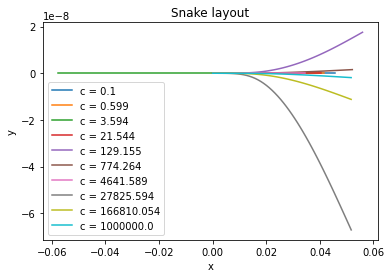

In [11]:
c_range = np.logspace(-1, 6, 10)
tip_thetas = []

for c in c_range:
    snake = SnakeExtra(B=1, c=c, l=1, rho=1)
    snake.solve()
    tip_theta = snake.sol.y[0][-1]
    tip_thetas.append(tip_theta)
    plt.plot(snake.x_pos, snake.y_pos, label=f"c = {round(c, 3)}")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Snake layout")
plt.show()

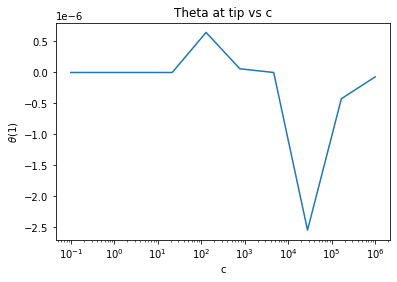

In [12]:
tip_thetas = np.array(tip_thetas)
plt.semilogx(c_range, tip_thetas)
plt.xlabel("c")
plt.ylabel(r"$\theta(1)$")
plt.title("Theta at tip vs c")
plt.show()

didn't work. 

### Try again but with 

\begin{equation}
    \theta(0) = 0 \\ 
    \frac{d\theta}{ds}(0) = 0 \\ 
    \theta(1) = \frac{\pi}{2}
\end{equation}

and try to get $\frac{d\theta}{ds}(1) = 0$

In [20]:
class SnakeExtra:
    def __init__(self, B, c, l, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((2, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        dy_ds = np.exp(-((self.x - 0.25) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, self.x, initial=0) / si.trapz(dy_ds, self.x)
        )
        self.y[0, :] = y_guess
        # self.y[0, 0] = 0
        # self.y[0, -1] = np.pi / 2
        self.y[1, :] = dy_ds  # np.exp(-(self.x-0.2)**2/.010)
        # self.y[1, 0] = 0
        # self.y[1, -1] = 0

    def fun_k(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = (
            self.B * (-l / self.lg) ** 3 * x * np.cos(y[0]) / (self.B + self.c)
        )  # need -g
        dy_dx = np.vstack((dy0_dx, dy1_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[0]
        res2 = ya[1]
        res3 = yb[0] - np.pi / 2
        residuals = np.array([res1, res2, res3])
        return residuals

    def solve(self):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l]
        )
        self.l = self.sol.p[0]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)

    def cost(self, alpha=0.5):
        height_term = self.y_pos[-1] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

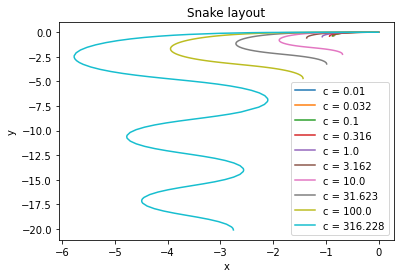

In [45]:
c_range = np.logspace(-2, 2.5, 10)
tip_derivs = []

for c in c_range:
    snake = SnakeExtra(B=1, c=c, l=1, rho=1)
    snake.solve()
    if snake.sol.status != 0:
        print("Failed")
    tip_deriv = snake.sol.y[1][-1]
    tip_derivs.append(tip_deriv)
    plt.plot(snake.x_pos, snake.y_pos, label=f"c = {round(c, 3)}")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Snake layout")
plt.show()

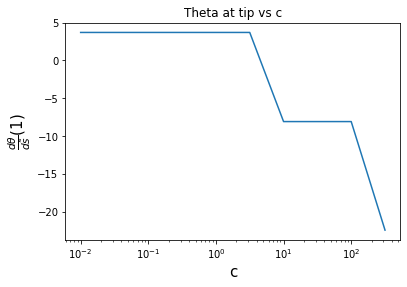

In [46]:
tip_derivs = np.array(tip_derivs)
plt.semilogx(c_range, tip_derivs)
plt.xlabel("c", fontsize=15)
plt.ylabel(r"$\frac{d\theta}{d\tilde{s}}(1)$", fontsize=15)
plt.title("Theta at tip vs c")
plt.show()

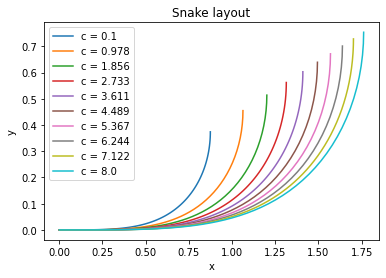

In [47]:
c_range = np.linspace(0.1, 8, 10)
tip_derivs = []

for c in c_range:
    snake = SnakeExtra(B=1, c=c, l=1, rho=1)
    snake.solve()
    if snake.sol.status != 0:
        print("Failed")
    tip_deriv = snake.sol.y[1][-1]
    tip_derivs.append(tip_deriv)
    plt.plot(-snake.x_pos, -snake.y_pos, label=f"c = {round(c, 3)}")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Snake layout")
plt.show()

In [50]:
snake = SnakeExtra(B=1, c=0.1, l=1, rho=1)

In [51]:
snake.solve()

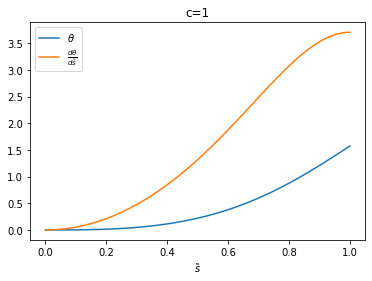

In [57]:
plt.plot(snake.sol.x, snake.sol.y[0], label=r"$\theta$")
plt.plot(snake.sol.x, snake.sol.y[1], label=r"$\frac{d\theta}{d\tilde{s}}$")
plt.xlabel(r"$\tilde{s}$")
plt.title("c=1")
plt.legend()
plt.show()

Also doesn't work. 

### Trying new set of boundary conditions and shooting

Try 
\begin{equation}
    \frac{d\theta}{ds}(0) = 0 \\ 
    \theta(1) = 0 \\ 
    \frac{d\theta}{ds}(1) = 0
\end{equation}

In [59]:
class SnakeExtra:
    def __init__(self, B, c, l, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((2, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        dy_ds = np.exp(-((self.x - 0.25) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, self.x, initial=0) / si.trapz(dy_ds, self.x)
        )
        self.y[0, :] = y_guess
        # self.y[0, 0] = 0
        # self.y[0, -1] = np.pi / 2
        self.y[1, :] = dy_ds  # np.exp(-(self.x-0.2)**2/.010)
        # self.y[1, 0] = 0
        # self.y[1, -1] = 0

    def fun_k(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = (
            self.B * (-l / self.lg) ** 3 * x * np.cos(y[0]) / (self.B + self.c)
        )  # need -g
        dy_dx = np.vstack((dy0_dx, dy1_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[1]
        res2 = yb[1]
        res3 = yb[0] - np.pi / 2
        residuals = np.array([res1, res2, res3])
        return residuals

    def solve(self):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l]
        )
        self.l = self.sol.p[0]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)

    def cost(self, alpha=0.5):
        height_term = self.y_pos[-1] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

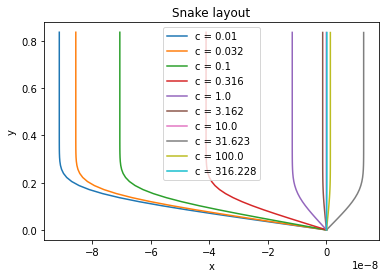

In [60]:
c_range = np.logspace(-2, 2.5, 10)
base_angles = []

for c in c_range:
    snake = SnakeExtra(B=1, c=c, l=1, rho=1)
    snake.solve()
    if snake.sol.status != 0:
        print("Failed")
    base_angle = snake.sol.y[0][0]
    base_angles.append(base_angle)
    plt.plot(snake.x_pos, snake.y_pos, label=f"c = {round(c, 3)}")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Snake layout")
plt.show()

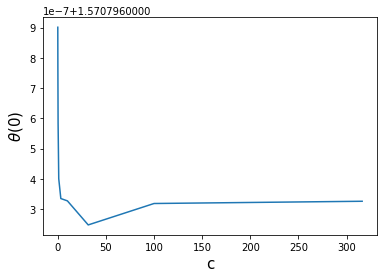

In [69]:
base_angles = np.array(base_angles)

plt.plot(c_range, base_angles)
plt.xlabel("c", fontsize=15)
plt.ylabel(r"$\theta(0)$", fontsize=15)
plt.show()

In [73]:
snake = SnakeExtra(B=1, c=31.623, l=1, rho=1)

In [74]:
snake.solve()

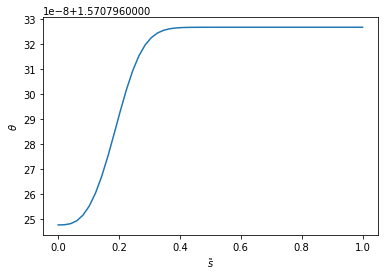

In [76]:
plt.plot(snake.sol.x, snake.sol.y[0])
plt.xlabel(r"$\tilde{s}$")
plt.ylabel(r"$\theta$")
plt.show()

Didn't work

## Let's try the last set

\begin{equation}
    \theta(0) = 0 \\ 
    \theta(1) = \frac{\pi}{2} \\ 
    \frac{d\theta}{ds}(1) = 0
\end{equation}

In [77]:
class SnakeExtra:
    def __init__(self, B, c, l, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((2, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        dy_ds = np.exp(-((self.x - 0.25) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, self.x, initial=0) / si.trapz(dy_ds, self.x)
        )
        self.y[0, :] = y_guess
        # self.y[0, 0] = 0
        # self.y[0, -1] = np.pi / 2
        self.y[1, :] = dy_ds  # np.exp(-(self.x-0.2)**2/.010)
        # self.y[1, 0] = 0
        # self.y[1, -1] = 0

    def fun_k(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = (
            self.B * (-l / self.lg) ** 3 * x * np.cos(y[0]) / (self.B + self.c)
        )  # need -g
        dy_dx = np.vstack((dy0_dx, dy1_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[0]
        res2 = yb[1]
        res3 = yb[0] - np.pi / 2
        residuals = np.array([res1, res2, res3])
        return residuals

    def solve(self):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l]
        )
        self.l = self.sol.p[0]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)

    def cost(self, alpha=0.5):
        height_term = self.y_pos[-1] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

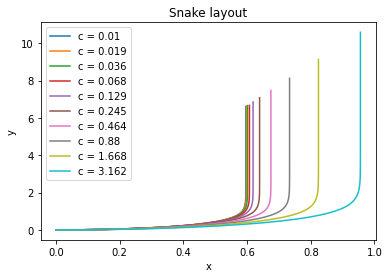

In [88]:
c_range = np.logspace(-2, 0.5, 10)
base_derivs = []

for c in c_range:
    snake = SnakeExtra(B=1, c=c, l=1, rho=1)
    snake.solve()
    if snake.sol.status != 0:
        print("Failed")
    base_deriv = snake.sol.y[1][0]
    base_derivs.append(base_deriv)
    plt.plot(snake.x_pos, snake.y_pos, label=f"c = {round(c, 3)}")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Snake layout")
plt.show()

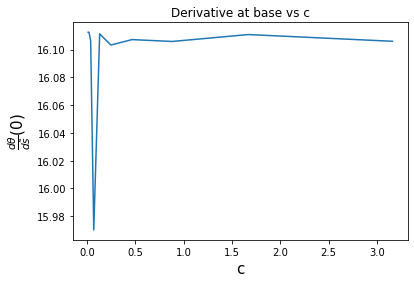

In [89]:
base_derivs = np.array(base_derivs)

plt.plot(c_range, base_derivs)
plt.xlabel("c", fontsize=15)
plt.ylabel(r"$\frac{d\theta}{d\tilde{s}}(0)$", fontsize=15)
plt.title("Derivative at base vs c")
plt.show()